# **IMU > EDA > DATA FACTORY**

### **Mission**
- Find the overview structure of data
- Evaluate quality of data
- Calibrate data if there are any errors

# **ATRIUM : Data Import & QC**

## **A1 - Import & Configuration**
---

### **A11 - IMPORT LIBRARIES**

In [202]:
# Import generally used libraries
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns

import math
from tqdm import tqdm
import random

## scipy
import scipy
import scipy.io as io
import scipy.signal as signal
import scipy.stats as stats

### **A12 - VISUAL INTERFACE CONFIGURATION**

In [203]:
# Configure fonts
FONT_PATH = "../../assets/font/PlusJakartaSans-{0}.ttf"

HEADING = "Bold"
LABEL = "Regular"
CONTENT = "Light"

# Font properties **kwargs -> usage: plt.some_method(**H_FONT)
H_FONT = {"fontproperties": fm.FontProperties(fname=FONT_PATH.format(HEADING)), "size": 8}
L_FONT = {"fontproperties": fm.FontProperties(fname=FONT_PATH.format(LABEL)), "size": 7}
C_FONT = {"fontproperties": fm.FontProperties(fname=FONT_PATH.format(CONTENT)), "size": 6}

# Configure pandas
pd.options.mode.chained_assignment = None  # default='warn'

# Configure plt rc params
%matplotlib inline
mpl.rcParams['grid.color'] = '#f0f0f0'
plt.rcParams['figure.dpi'] = 300

In [204]:
# Color palattes for candlestick chart
C_BULL = "#51A299"
C_BEAR = "#DD5E57"

C_SLATE500 = '#64748B'

# Color from tailwind.css HSB500 https://tailwindcss.com/docs/customizing-colors
TRI_PALETTE = ['#F43F5E', '#F59E0B', '#6366F1'] # color theme for plotting: red yellow blue
UNI_PALETTE = ['#EF4444', "#F59E0B", "#FDE047", "#84CC16", 
               "#14B8A6", "#0EA5E9", "#3B82F6", "#8B5CF6", 
               "#D946EF", "#64748B", "#44403C"] # rainbow color theme

### **A13 - MAGIC FUNCTION**

In [205]:
def coor_array_to_df(coor_array: list) -> pd.DataFrame:
    """ Custom function: convert list of coordinate (x, y) to pd.DataFrame
        Input:
            coor_array: list of coordinate (x, y)
        Output:
            pd.DataFrame which contains column name [x, y]"""
    return pd.DataFrame(data=coor_array, columns=["x", "y"])

## **A2 - Data Structure**
---

### **A21 - PREVIEW FILE STRUCTURE**

#### **File Hierarchy**
- `SUBJECT`: type of `[SUBJ1, SUBJ2]`

    - `over_ground`

        - `${limb}_SUBJ_walk_${speed}.csv` data of (x, y) coordinates timeseries, where

            - `limb`: type of `[LA, RA, LF, RF]`

            - `speed`: type of `[slow, comfortable, fast]`

    - `treadmill`

        - `${limb}_SUBJ_walk_${speed}.csv` data of (x, y) coordinates timeseries, where

            - `limb`: type of `[LA, RA, LF, RF]`
                
            - `speed`: type of `[40, 55, 70, 85, 100]`

### **A22 - DATA STRUCTURING**

In [206]:
# Define File hiererchy in to dict structure
DATA_HIERARCHY = {
    "subject": ["SUBJ1", "SUBJ2"],
    "mode": ["over_ground", "treadmill"],
    "limb": ["LA", "RA", "LF", "RF"],
    "speed": {
        "over_ground": ["slow", "comfortable", "fast"],
        "treadmill": [40, 55, 70, 85, 100]
    }
}

# Define list of all combination props of data files
DATA_TABLE_PROPS = [(_subj, _mode, _limb, _speed, "", 0, []) 
    for _subj in DATA_HIERARCHY["subject"]
    for _mode in DATA_HIERARCHY["mode"]
    for _limb in DATA_HIERARCHY["limb"]
    for _speed in DATA_HIERARCHY["speed"][_mode]]

# Define dataframe template of all data
DATA_TABLE = pd.DataFrame(columns=["subj", "mode", "limb", "speed", "tag", "coorlen", "coor"], data=DATA_TABLE_PROPS).astype({
    "subj": "category",
    "mode": "category",
    "limb": "category",
    "speed": "category",
    "tag": "string",
    "coorlen": "int",
    "coor": "object"
})

## **A3 - Data Fetching**
---

### **A31 - DATA FETCHING**

In [207]:
# Fetch data and store it in DATA_TABLE
for index, (_subj, _exp, _limb, _speed, _tag, _coorlen, _coor) in tqdm(enumerate(DATA_TABLE_PROPS)):
    # Read csv
    _temp_df = pd.read_csv(
        f"../../data/{_subj}/{_exp}/csvOP/{_limb}_{_subj}_walk_{_speed}.csv",
        dtype=float,
        names=["x", "y"])
    # Assign value to DATA_TABLE
    DATA_TABLE.at[index, "tag"] = f"{_subj}_{_exp}_{_limb}_{_speed}"
    DATA_TABLE.at[index, "coorlen"] = _temp_df.shape[0]
    DATA_TABLE.at[index, "coor"] = {"x": _temp_df.T.values.tolist()[0], "y": _temp_df.T.values.tolist()[1]}

64it [00:00, 444.15it/s]


### **A32 - DATA PREVIEW & QC**

In [214]:
# Preview data
DATA_TABLE

,subj,mode,limb,speed,tag,coorlen,coor
0,SUBJ1,over_ground,LA,slow,SUBJ1_over_ground_LA_slow,15577,"{'x': [0.27468, 0.26212, 0.24909, 0.23492, 0.2..."
1,SUBJ1,over_ground,LA,comfortable,SUBJ1_over_ground_LA_comfortable,15425,"{'x': [-0.33781, -0.35069, -0.36408, -0.37772,..."
2,SUBJ1,over_ground,LA,fast,SUBJ1_over_ground_LA_fast,14508,"{'x': [-0.12275, -0.12454, -0.12697, -0.13016,..."
3,SUBJ1,over_ground,RA,slow,SUBJ1_over_ground_RA_slow,15577,"{'x': [-0.31409, 0.32838, 0.34263, 0.35651, 0...."
4,SUBJ1,over_ground,RA,comfortable,SUBJ1_over_ground_RA_comfortable,15425,"{'x': [0.36911, -0.35088, -0.33103, -0.31626, ..."
...,...,...,...,...,...,...,...
59,SUBJ2,treadmill,RF,40,SUBJ2_treadmill_RF_40,10976,"{'x': [0.20285, 0.21062, 0.22262, 0.23659, 0.2..."
60,SUBJ2,treadmill,RF,55,SUBJ2_treadmill_RF_55,11159,"{'x': [-0.0031709, -0.025288, -0.057988, -0.09..."
61,SUBJ2,treadmill,RF,70,SUBJ2_treadmill_RF_70,11287,"{'x': [-0.26458, -0.25398, -0.23914, -0.22289,..."
62,SUBJ2,treadmill,RF,85,SUBJ2_treadmill_RF_85,11103,"{'x': [0.02495, 0.036426, 0.053363, 0.072636, ..."


In [213]:
# Preview data properties
DATA_TABLE.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   subj     64 non-null     category
 1   mode     64 non-null     category
 2   limb     64 non-null     category
 3   speed    64 non-null     category
 4   tag      64 non-null     string  
 5   coorlen  64 non-null     int64   
 6   coor     64 non-null     object  
dtypes: category(4), int64(1), object(1), string(1)
memory usage: 2.7+ KB


# **BEACON : Data Integrity Test**

## **B1 - Data Distribution**
---

### **B11 - BIRDEYE VIEW FOR DEFECT SKIMMING**

In [212]:
# Visualize all data
plt.style.use('_mpl-gallery-nogrid')

len_data = len(DATA_TABLE)
n_cols = 8
n_rows = math.ceil(len_data/8)

fig, axs = plt.subplots(n_cols, n_rows, figsize=(n_cols*3, n_rows*3))
fig.tight_layout()

# Plot all subplots
for index, (ax) in enumerate(axs.ravel()):
    # Prepare data
    sample_data = coor_array_to_df(DATA_TABLE.loc[index, "coor"])
    title = DATA_TABLE.loc[index, "tag"]

    # Plot
    ax.hist2d(x=sample_data["x"], y=sample_data["y"], bins=[100, 100])

    # Axes properties
    ax.set_title(title, **H_FONT)
    # ax.set_xlabel('X pos', **L_FONT)
    # ax.set_ylabel('Y pos', **L_FONT)

    # Plot properties
    plt.sca(ax)
    plt.xticks(**C_FONT)
    plt.yticks(**C_FONT)

plt.savefig("../../src/eda/image/hist2d_all_data", dpi=300)

### **B12 - DATA BALANCE**

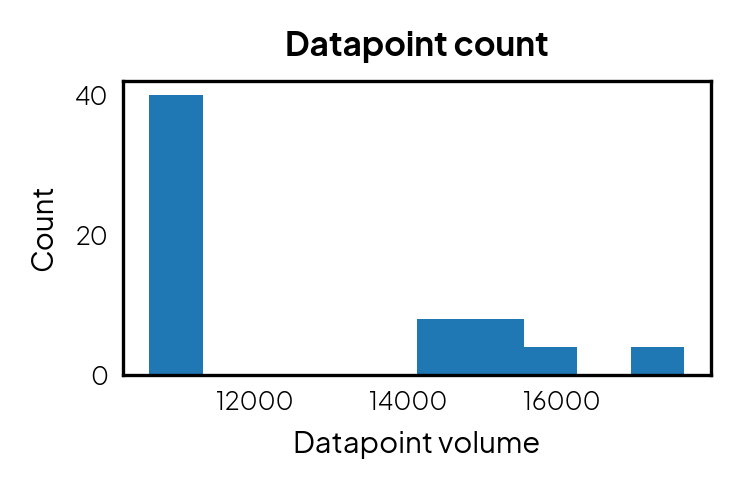

In [255]:
# Visualize all data
plt.style.use('_mpl-gallery-nogrid')

fig, ax = plt.subplots(1, 1, figsize=(2, 1))

# Prepare data
data = DATA_TABLE.loc[:, "coorlen"]
title = "Datapoint count"

# Plot
ax.hist(x=data, bins=10)

# Axes properties
ax.set_title(title, **H_FONT)
ax.set_xlabel('Datapoint volume', **L_FONT)
ax.set_ylabel('Count', **L_FONT)

# Plot properties
plt.xticks(**C_FONT)
plt.yticks(**C_FONT)

plt.savefig("../../src/eda/image/hist_datapoint_density", dpi=300)

In [224]:
# Check what data are the outliners
DATA_TABLE.loc[(DATA_TABLE.coorlen > 13000), :].reset_index(drop=False)

,index,subj,mode,limb,speed,tag,coorlen,coor
0,0,SUBJ1,over_ground,LA,slow,SUBJ1_over_ground_LA_slow,15577,"{'x': [0.27468, 0.26212, 0.24909, 0.23492, 0.2..."
1,1,SUBJ1,over_ground,LA,comfortable,SUBJ1_over_ground_LA_comfortable,15425,"{'x': [-0.33781, -0.35069, -0.36408, -0.37772,..."
2,2,SUBJ1,over_ground,LA,fast,SUBJ1_over_ground_LA_fast,14508,"{'x': [-0.12275, -0.12454, -0.12697, -0.13016,..."
3,3,SUBJ1,over_ground,RA,slow,SUBJ1_over_ground_RA_slow,15577,"{'x': [-0.31409, 0.32838, 0.34263, 0.35651, 0...."
4,4,SUBJ1,over_ground,RA,comfortable,SUBJ1_over_ground_RA_comfortable,15425,"{'x': [0.36911, -0.35088, -0.33103, -0.31626, ..."
5,5,SUBJ1,over_ground,RA,fast,SUBJ1_over_ground_RA_fast,14508,"{'x': [-0.10467, 0.10265, 0.099792, 0.094247, ..."
6,6,SUBJ1,over_ground,LF,slow,SUBJ1_over_ground_LF_slow,15577,"{'x': [-0.0031041, -0.003741, -0.0045764, -0.0..."
7,7,SUBJ1,over_ground,LF,comfortable,SUBJ1_over_ground_LF_comfortable,15425,"{'x': [-0.024416, -0.026548, -0.028637, -0.030..."
8,8,SUBJ1,over_ground,LF,fast,SUBJ1_over_ground_LF_fast,14508,"{'x': [-0.015332, -0.016116, -0.016581, -0.016..."
9,9,SUBJ1,over_ground,RF,slow,SUBJ1_over_ground_RF_slow,15577,"{'x': [0.010472, -0.010213, -0.010114, -0.0100..."


In [254]:
# Compare over_ground & treadmill data points statistics
print("over_ground")
print(f"    count           {len(DATA_TABLE.loc[(DATA_TABLE["mode"] == "over_ground"), "coorlen"])}")
print(f"    mean            {np.mean(DATA_TABLE.loc[(DATA_TABLE["mode"] == "over_ground"), "coorlen"])}")
print(f"    std             {np.std(DATA_TABLE.loc[(DATA_TABLE["mode"] == "over_ground"), "coorlen"])}")
print(f"    count x mean    {len(DATA_TABLE.loc[(DATA_TABLE["mode"] == "over_ground"), "coorlen"]) * np.mean(DATA_TABLE.loc[(DATA_TABLE["mode"] == "over_ground"), "coorlen"])}")

print("\ntreadmill")
print(f"    count           {len(DATA_TABLE.loc[(DATA_TABLE["mode"] == "treadmill"), "coorlen"])}")
print(f"    mean            {np.mean(DATA_TABLE.loc[(DATA_TABLE["mode"] == "treadmill"), "coorlen"])}")
print(f"    std             {np.std(DATA_TABLE.loc[(DATA_TABLE["mode"] == "treadmill"), "coorlen"])}")
print(f"    count x mean    {len(DATA_TABLE.loc[(DATA_TABLE["mode"] == "treadmill"), "coorlen"]) * np.mean(DATA_TABLE.loc[(DATA_TABLE["mode"] == "treadmill"), "coorlen"])}")

over_ground
    count           24
    mean            15420.666666666666
    std             1064.617719601214
    count x mean    370096.0

treadmill
    count           40
    mean            11058.6
    std             162.51842972413928
    count x mean    442344.0


## **B2 - SIGNAL CALIBRATION**
---